# Objective #1

In [493]:
from itertools import product
import json

from matplotlib import pyplot as plt
from os.path import exists
import numpy as np
import pandas as pd
from sklearn import tree, linear_model
from sklearn.metrics import *
from scipy.stats import pearsonr

import random
np.random.seed(0)
random.seed(0)

from pathlib import Path
def append2file(text: str):
    myfile = Path('results.txt')
    myfile.touch(exist_ok=True)
    
    f = open(myfile, "a")
    f.write(text)
    f.close()

append2file("\n\nObjective 1 - Regression Models\n\n")

In [494]:
df = pd.read_csv("parkinsons_updrs.data")
n, m = df.shape

## 1.0. Data sett inspection

['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']


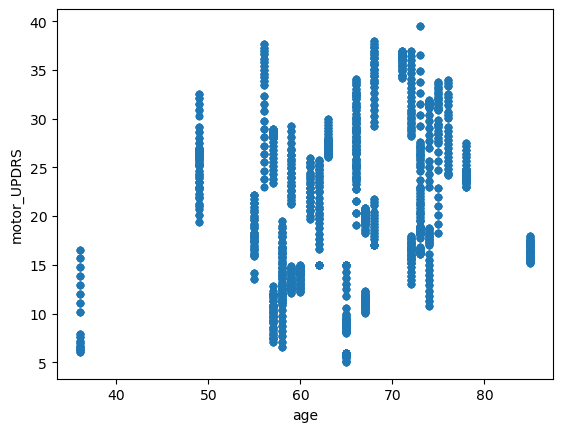

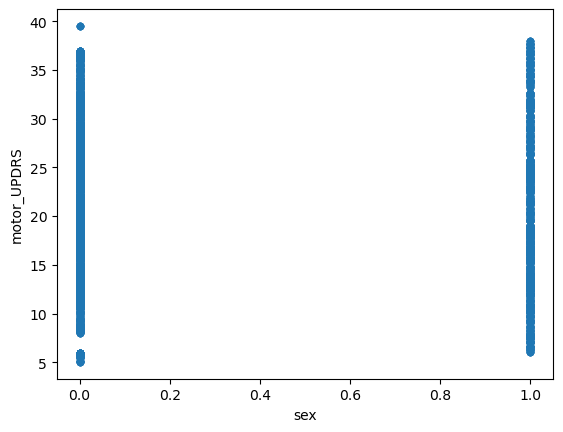

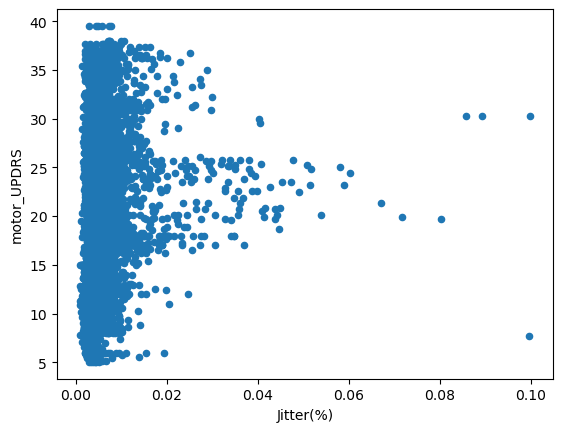

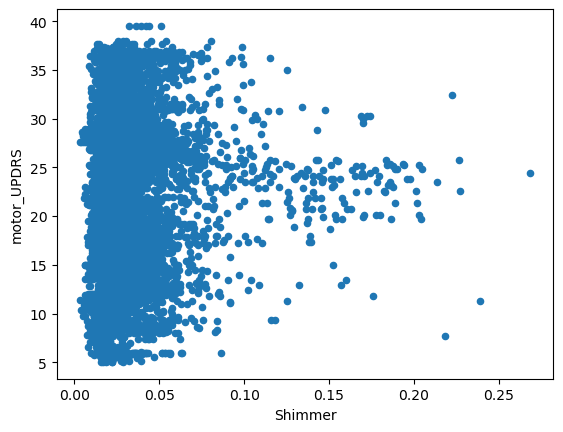

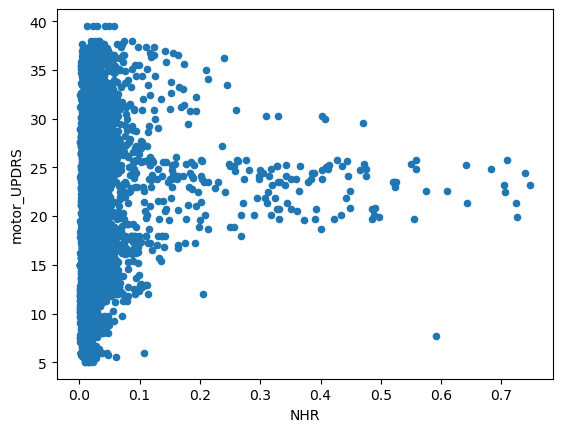

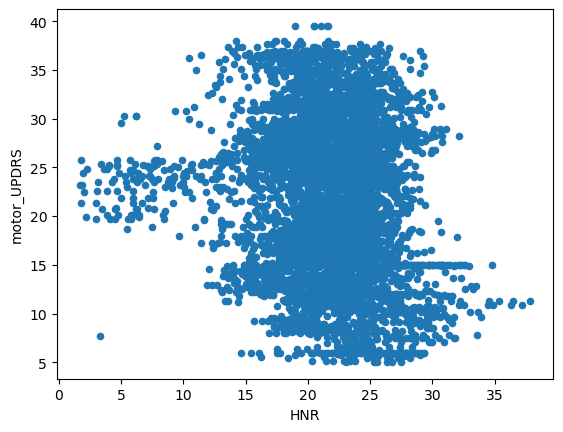

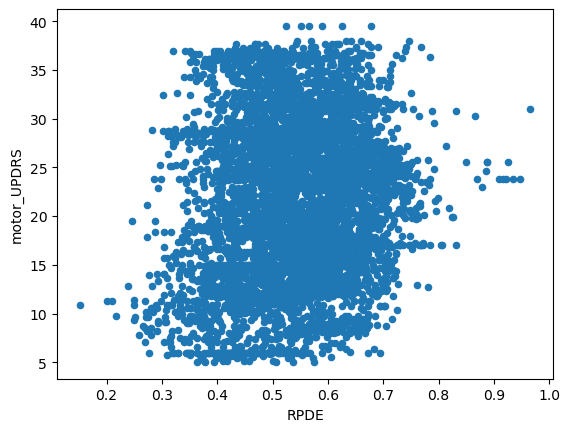

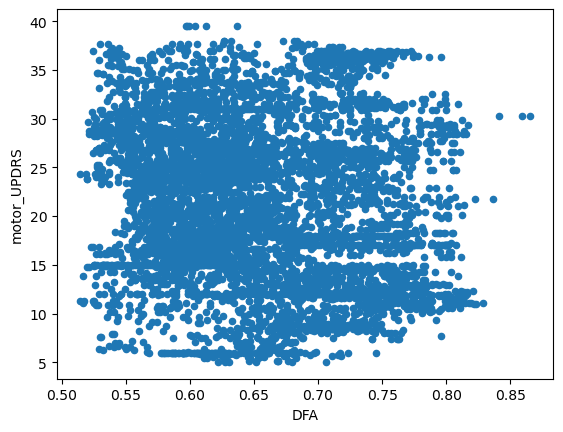

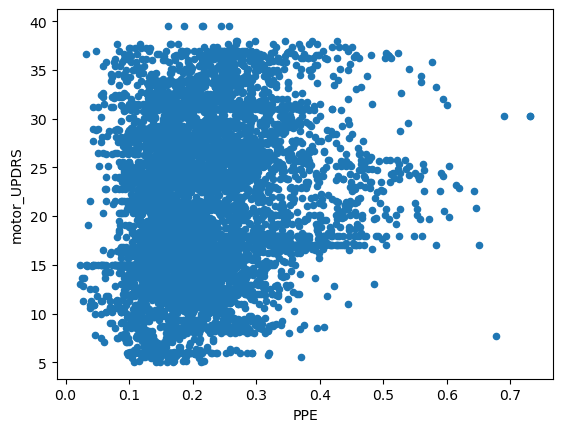

In [495]:
columns = list(df.columns.values)
print(columns)
x_columns = columns[6:]
for x_col in ['age', 'sex', 'Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']:
    df.plot.scatter(x=x_col, y="motor_UPDRS")


## 1.1. Dataset preparation
### 1.1.1. Shuffle and Split into training and IVS
- `train_df` -- training set for model training/selection
- `ivs_df` -- independet validation set (IVS) for the final benchmark

In [496]:
df = df.sample(frac=1)
train_size = int(0.8 * n)
train_df = df.iloc[:train_size]
ivs_df = df.iloc[train_size:]
append2file("\nStarting new Tests\n\n")

In [497]:
#['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
#x_cols = ['age', 'sex', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'HNR', 'RPDE', 'DFA', 'PPE']
x_cols = ['age', 'sex', 'Jitter(Abs)', 'Shimmer', 'HNR', 'RPDE', 'DFA', 'PPE']
#train_x = np.array(train_df[['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']])
train_x = np.array(train_df[x_cols])
train_y = np.array(train_df["motor_UPDRS"])

#ivs_x = np.array(ivs_df[['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']])
ivs_x = np.array(ivs_df[x_cols])
ivs_y = np.array(ivs_df["motor_UPDRS"])

### 1.1.2. Scale data

In [498]:
x_mean  = np.mean(train_x, axis=0)
x_std   = np.std(train_x, axis=0)
train_x = (train_x - x_mean) / x_std
y_mean  = np.mean(train_y, axis=0)
y_std  = np.std(train_y, axis=0)
train_y = (train_y - y_mean) / y_std
ivs_x_scaled = (ivs_x - np.mean(ivs_x, axis=0)) / np.std(ivs_x, axis=0)
ivs_y_scaled   = (ivs_y - np.mean(ivs_y, axis=0)) / np.std(ivs_y, axis=0)

### 1.2.Validation techniques (shared for regression and classification)

In [499]:
def simple_cross_validation(*, model, x, y, train_partition=(0, 0.8), metrics={"mae": mean_absolute_error}):
    n, m = x.shape
    
    start = int(train_partition[0] * n)
    end = int(train_partition[1] * n)
    
    x_train = x[start:end, :]
    y_train = y[start:end]
    x_test = np.concatenate((x[:start, :], x[end:, :]))
    y_test = np.concatenate((y[:start], y[end:]))
    
    #print("SCV")
    #print(x_train)
    #print(y_train)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    return {metric_name: metric_f(y_test, y_pred) for (metric_name, metric_f) in metrics.items()}


def kfold(*, model, x, y, k=5, metrics={"mae": mean_absolute_error}):
    n, m = x.shape
    results = {metric: 0 for metric in metrics.keys()}
    
    for i in range(k):
        start = i * (1/k)
        end = start + (1/k)
        if (i + 1) == k:
            end = 1.0
            
        iteration_results = simple_cross_validation(model=model, x=x, y=y, train_partition=(start, end), metrics=metrics)
        
        for metric in metrics.keys():
            results[metric] += iteration_results[metric]
    
    for metric in results.keys():
        results[metric] /= k
    
    return results

### 1.3. Model Selection

In [500]:
def results2df(test_name: str, hyperparams_names, hyperparams_values, results, metrics):
    if len(hyperparams_names) > 1:
        index = pd.MultiIndex.from_tuples(hyperparams_values, names=hyperparams_names)
    else:
        index = pd.Index(hyperparams_values, name=hyperparams_names[0])
    data = [[m for m in v["evaluation"].values()] for v in results.values()]
    results = pd.DataFrame(data, index=index, columns=metrics.keys())
    results = results.style.format({m: '{:.3f}' for m in metrics.keys()}, escape="latex").format_index(escape="latex")
    print(results.to_latex())

    
    myfile = Path('results.txt')
    myfile.touch(exist_ok=True)
    f = open(myfile, "a")
    
    f.write("\n" + test_name + "\n")
    f.write(str(results.to_latex()))
    f.write("\n --- \n")

    f.close()

    return results




def tree_regressor_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    # Hyperparameters
    ####
    #criterions = ["squared_error", "friedman_mse"]
    #splitters = ["best"]
    #max_depths = [5, 10, 20, 50, None]
    #hyper_parameters = list(product(criterions, splitters, max_depths))
    #### tree-friedman_mse-best-10-None-3-4-40
    #criterions = ["squared_error", "friedman_mse", "absolute_error"] #, "poisson"] # poisson regression can not happen since y has negative values
    #splitters = ["best"]
    #max_depths = [None,10]#20, 50, None]
    #max_features = [None]#["sqrt", "log2", None]
    #min_samples_leaf = [1,3]#range(1,30,1)
    #min_samples_splits = [2,4]#range(2,30,1)
    #max_leaf_nodes = [None,40]#,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    #hyper_parameters = list(product(criterions, splitters, max_depths, max_features, min_samples_leaf, min_samples_splits, max_leaf_nodes))
    ####
    criterions = ["squared_error", "friedman_mse"]#, "absolute_error"] #, "poisson"] # poisson regression can not happen since y has negative values
    #splitters = ["best"]
    max_depths = [None,10]#20, 50, None]
    #max_features = [None]#["sqrt", "log2", None]
    min_samples_leaf = [1,3]#range(1,30,1)
    min_samples_splits = [2,4]#range(2,30,1)
    max_leaf_nodes = [None,40]#,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    hyper_parameters = list(product(criterions, max_depths, min_samples_leaf, min_samples_splits, max_leaf_nodes))

    results = {}
    
    for p in hyper_parameters:

        ####
        #criterion, splitter, max_depth = p
        #
        #model = tree.DecisionTreeRegressor(criterion=criterion,
        #                                   splitter=splitter,
        #                                   max_depth=max_depth)
        #
        ####
        #criterion, splitter, max_depth, max_features, min_samples_leaf, min_samples_split, max_leaf_nodes = p
        #
        #model = tree.DecisionTreeRegressor(criterion=criterion,
        #                                    splitter=splitter,
        #                                    max_depth=max_depth,
        #                                    max_features=max_features,
        #                                    min_samples_leaf=min_samples_leaf,
        #                                    min_samples_split=min_samples_split,
        #                                    max_leaf_nodes=max_leaf_nodes)
        ####
        criterion, max_depth, min_samples_leaf, min_samples_split, max_leaf_nodes = p
        
        model = tree.DecisionTreeRegressor(criterion=criterion,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            min_samples_split=min_samples_split,
                                            max_leaf_nodes=max_leaf_nodes)

        model_results = validation(model, x, y, metrics)
        model_name = "tree-" + "-".join([str(param) for param in p])
        results[model_name] = {"model": model, "evaluation": model_results}

    ####
    #results2df("\nTree Regressor Selection\n", ["criterion", "splitter", "max_depth"], hyper_parameters, results, metrics)
    ####
    #results2df("\nTree Regressor Selection\n", ["criterion", "splitter", "max_depth", "max_features", "min_samples_leaf", "min_samples_split", "max_leaf_nodes"], hyper_parameters, results, metrics)
    ####
    results2df("\nTree Regressor Selection\n", ["criterion", "max_depth", "min_samples_leaf", "min_samples_split", "max_leaf_nodes"], hyper_parameters, results, metrics)
    ####
    
    return results


def linear_regression_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    results = {}

    model = linear_model.LinearRegression()
    model_results = validation(model, x, y, metrics)
    results[f"lineareg"] = {"model": model, "evaluation": model_results}

    return results


def ridge_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    results = {}
    
    alphas = [*[10**p for p in range(-5,2)], *[]]
    for alpha in alphas:
        model = linear_model.Ridge(alpha=alpha)
        model_results = validation(model, x, y, metrics)
        results[f"ridge-{alpha}"] = {"model": model, "evaluation": model_results}
        
    results2df("\nRidge Selection\n", ["alpha"], alphas, results, metrics)
        
    return results

def lasso_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    results = {}
    
    alphas = [*[10**p for p in range(-5,2)], *[]]
    for alpha in alphas:
        model = linear_model.Lasso(alpha=alpha)
        model_results = validation(model, x, y, metrics)
        results[f"lasso-{alpha}"] = {"model": model, "evaluation": model_results}
        
    results2df("\nLasso Selection\n", ["alpha"], alphas, results, metrics)
    return results

        
def model_selection(x: np.ndarray, y: np.ndarray):
    metrics = {"mae": lambda y_true, y_pred: y_std * mean_absolute_error(y_true, y_pred), "rve": explained_variance_score, "r2": r2_score}
    validation_technique = lambda model, x, y, metrics: kfold(model=model, x=x, y=y, k=10, metrics=metrics)
    
    results = {}
    results |= tree_regressor_selection(x, y, metrics, validation_technique)
    results |= linear_regression_selection(x, y, metrics, validation_technique)
    results |= ridge_selection(x, y, metrics, validation_technique)
    results |= lasso_selection(x, y, metrics, validation_technique)
    
    best_model_name = max(results, key=lambda model: results[model]["evaluation"]["rve"])
    best_model = results[best_model_name] | {"name": best_model_name}
        
    return best_model, results

best_regressor, other_regressors = model_selection(train_x, train_y)

append2file(f"\n\nBest Model: {best_regressor['name']}\nBest Model Results: {best_regressor['evaluation']}\n\n-----")
print(f"Best Model: {best_regressor['name']}")
print(f"Best Model Results: {best_regressor['evaluation']}")
# print(json.dumps({"-".join([str(p) for p in k]): v["avg_evaluation"] for (k, v) in results.items()}, indent=4))

\begin{tabular}{lllllrrr}
 &  &  &  &  & mae & rve & r2 \\
criterion & max_depth & min_samples_leaf & min_samples_split & max_leaf_nodes &  &  &  \\
\multirow[c]{16}{*}{squared\_error} & \multirow[c]{8}{*}{nan} & \multirow[c]{4}{*}{1} & \multirow[c]{2}{*}{2} & nan & 3.733 & 0.462 & 0.460 \\
 &  &  &  & 40.000000 & 3.629 & 0.537 & 0.536 \\
 &  &  & \multirow[c]{2}{*}{4} & nan & 3.657 & 0.483 & 0.482 \\
 &  &  &  & 40.000000 & 3.618 & 0.541 & 0.540 \\
 &  & \multirow[c]{4}{*}{3} & \multirow[c]{2}{*}{2} & nan & 3.666 & 0.517 & 0.515 \\
 &  &  &  & 40.000000 & 3.619 & 0.548 & 0.547 \\
 &  &  & \multirow[c]{2}{*}{4} & nan & 3.658 & 0.516 & 0.515 \\
 &  &  &  & 40.000000 & 3.617 & 0.550 & 0.549 \\
 & \multirow[c]{8}{*}{10.000000} & \multirow[c]{4}{*}{1} & \multirow[c]{2}{*}{2} & nan & 3.664 & 0.487 & 0.485 \\
 &  &  &  & 40.000000 & 3.604 & 0.544 & 0.543 \\
 &  &  & \multirow[c]{2}{*}{4} & nan & 3.609 & 0.508 & 0.506 \\
 &  &  &  & 40.000000 & 3.590 & 0.547 & 0.546 \\
 &  & \multirow[c]{4}{*

# Objective #2

## 2.1. Prepare data

In [501]:
#train_x = np.array(train_df[['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']])
train_x = np.array(train_df[x_cols])
train_y = np.array(train_df["total_UPDRS"])

#ivs_x = np.array(ivs_df[['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']])
ivs_x = np.array(ivs_df[x_cols])
ivs_y = np.array(ivs_df["total_UPDRS"])

train_y = np.array(train_y > 40, dtype=bool).astype(int)  # 801 positivos, 3899 negativos
print(f"No. positives: {len(train_y[np.nonzero(train_y)])}")
print(f"No. negatives: {len(train_y) - len(train_y[np.nonzero(train_y)])}")
ivs_y = np.array(ivs_y > 40, dtype=bool).astype(int)

x_mean  = np.mean(train_x, axis=0)
x_std   = np.std(train_x, axis=0)
train_x = (train_x - x_mean) / x_std
ivs_x_scaled = (ivs_x - np.mean(ivs_x, axis=0)) / np.std(ivs_x, axis=0)

append2file("\n\nObjective 2 - Binary Classification Models\n\n")

No. positives: 796
No. negatives: 3904


## 2.2. Model selection

In [502]:
def tree_classifier_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    # Hyperparameters
    ####
    #criterions = ["gini", "entropy"]
    #splitters = ["best"]
    #max_depths = [5, 10, 20, 50, None]
    #hyper_parameters = list(product(criterions, splitters, max_depths))
    ####
    #criterions = ["gini", "entropy", "log_loss"]
    #splitters = ["best"]
    #max_depths = [40,None]
    #max_features = ["sqrt", "log2", None]
    #min_samples_leaf = [1,5]#range(1,30,1)
    #min_samples_splits = [2,4]#range(2,30,1)
    #max_leaf_nodes = [None,30,40]#[None,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    #hyper_parameters = list(product(criterions, splitters, max_depths, max_features, min_samples_leaf, min_samples_splits, max_leaf_nodes))
    #### tree-entropy-best-40-None-1-4-None
    criterions = ["gini", "entropy", "log_loss"]
    #splitters = ["best"]
    max_depths = [40,None]
    #max_features = ["sqrt", "log2", None]
    #min_samples_leaf = [1,5]#range(1,30,1)
    min_samples_splits = [2,4]#range(2,30,1)
    #max_leaf_nodes = [None,30,40]#[None,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    hyper_parameters = list(product(criterions, max_depths, min_samples_splits))

    results = {}
    
    for p in hyper_parameters:

        ####
        #criterion, splitter, max_depth = p
        #
        #model = tree.DecisionTreeClassifier(criterion=criterion,
        #                                    splitter=splitter,
        #                                    max_depth=max_depth)
        ####
        #criterion, splitter, max_depth, max_features, min_samples_leaf, min_samples_split, max_leaf_nodes = p
        #
        #model = tree.DecisionTreeClassifier(criterion=criterion,
        #                                    splitter=splitter,
        #                                    max_depth=max_depth,
        #                                    max_features=max_features,
        #                                    min_samples_leaf=min_samples_leaf,
        #                                    min_samples_split=min_samples_split,
        #                                    max_leaf_nodes=max_leaf_nodes, class_weight={0:1,1:4})
        ####
        criterion, max_depth, min_samples_split = p
        
        model = tree.DecisionTreeClassifier(criterion=criterion,
                                            max_depth=max_depth,
                                            min_samples_split=min_samples_split, class_weight={0:1,1:4})
        ####

        model_results = validation(model, x, y, metrics)
        model_name = "tree-" + "-".join([str(param) for param in p])
        results[model_name] = {"model": model, "evaluation": model_results}

    ####
    #results2df("\nTree Classifier Selection\n", ["criterion", "splitter", "max_depth"], hyper_parameters, results, metrics)
    ####
    #results2df("\nTree Classifier Selection\n", ["criterion", "splitter", "max_depth", "max_features", "min_samples_leaf", "min_samples_split", "max_leaf_nodes"], hyper_parameters, results, metrics)
    ####
    results2df("\nTree Classifier Selection\n", ["criterion", "max_depth", "min_samples_split"], hyper_parameters, results, metrics)
    ####

    return results

def logistic_regression_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    results = {}

    model = linear_model.LogisticRegression(random_state=0, class_weight={0:1,1:4})
    
    model_results = validation(model, x, y, metrics)
    results["logistic"] = {"model": model, "evaluation": model_results}

    return results

        
def model_selection(x: np.ndarray, y: np.ndarray):
    metrics = {"acc": accuracy_score, "f1": f1_score, "recall": recall_score, "precision": precision_score}
    validation_technique = lambda model, x, y, metrics: kfold(model=model, x=x, y=y, k=10, metrics=metrics)
    
    results = {}
    results = { **results, **tree_classifier_selection(x, y, metrics, validation_technique) }
    results = { **results, **logistic_regression_selection(x, y, metrics, validation_technique) }
    
    best_model_name = max(results, key=lambda model: results[model]["evaluation"]["f1"])
    best_model = {**results[best_model_name], **{"name": best_model_name}}

    best_model["model"] = best_model["model"].fit(x, y)
        
    return best_model, results
    

best_classifier, other_classifiers = model_selection(train_x, train_y)
append2file(f"\n\nBest Model: {best_classifier['name']}\nBest Model Results: {best_classifier['evaluation']}\n\n-----")
print(f"Best Model: {best_classifier['name']}")
print(f"Best Model Results: {best_classifier['evaluation']}")

\begin{tabular}{lllrrrr}
 &  &  & acc & f1 & recall & precision \\
criterion & max_depth & min_samples_split &  &  &  &  \\
\multirow[c]{4}{*}{gini} & \multirow[c]{2}{*}{40.000000} & 2 & 0.870 & 0.618 & 0.623 & 0.614 \\
 &  & 4 & 0.867 & 0.620 & 0.641 & 0.602 \\
 & \multirow[c]{2}{*}{nan} & 2 & 0.872 & 0.623 & 0.624 & 0.622 \\
 &  & 4 & 0.867 & 0.620 & 0.644 & 0.599 \\
\multirow[c]{4}{*}{entropy} & \multirow[c]{2}{*}{40.000000} & 2 & 0.871 & 0.617 & 0.619 & 0.619 \\
 &  & 4 & 0.870 & 0.623 & 0.636 & 0.613 \\
 & \multirow[c]{2}{*}{nan} & 2 & 0.873 & 0.621 & 0.618 & 0.627 \\
 &  & 4 & 0.870 & 0.620 & 0.628 & 0.614 \\
\multirow[c]{4}{*}{log\_loss} & \multirow[c]{2}{*}{40.000000} & 2 & 0.874 & 0.628 & 0.627 & 0.630 \\
 &  & 4 & 0.870 & 0.619 & 0.627 & 0.614 \\
 & \multirow[c]{2}{*}{nan} & 2 & 0.874 & 0.627 & 0.626 & 0.628 \\
 &  & 4 & 0.871 & 0.621 & 0.628 & 0.617 \\
\end{tabular}

Best Model: tree-log_loss-40-2
Best Model Results: {'acc': 0.8742080378250592, 'f1': 0.6275214563416871, 'rec

In [503]:
# Save all data into disk as a backup
df = pd.DataFrame(best_regressor)
if not exists("./best_regressors/best_regressor.json"):
    df.to_json("./best_regressors/best_regressor.json")
else:
    for i in range(0,100):
        p = f"./best_regressors/best_regressor_{i}.json"
        if not exists(p):
            df.to_json(p)
            break


df = pd.DataFrame(best_classifier)
if not exists("./best_classifiers/best_classifier.json"):
    df.to_json("./best_classifiers/best_classifier.json")
else:
    for i in range(0,100):
        p = f"./best_classifiers/best_classifier{i}.json"
        if not exists(p):
            df.to_json(p)
            break

c:\Users\rapos\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


## 3. Validate against IVS




format of the model name:
 - model_type(tree vs linear vs ...), criterions, splitters, max_depths

 - model_type(tree vs linear vs ...), criterions, splitters, max_depths, max_features, min_samples_leaf, min_samples_splits, max_leaf_nodes


--- Regressor ---
Model: tree-friedman_mse-10-1-4-40
Performance on IVS: {'mae': 0.44971198663826745, 'rve': 0.5430503832050402, 'pearson_corr': (0.7503882416563327, 3.853807369440189e-213)}
MAE (re-scaled): 3.646189254263551 
RVE: 0.5430503832050402
Pearson Correlation Score: (0.7503882416563327, 3.853807369440189e-213)

--- Classifier ---
Model: tree-log_loss-40-2
Performance on IVS: {'acc': 0.9225531914893617, 'f1': 0.7908045977011495, 'recall': 0.819047619047619, 'precision': 0.7644444444444445, 'matthews_corr': 0.7440204008509572, 'confusion_matrix': array([[912,  53],
       [ 38, 172]], dtype=int64)}
Accuracy: 0.9225531914893617
F1: 0.7908045977011495
Precision: 0.7644444444444445
Recall: 0.819047619047619
Matthews Correlation Coefficient:

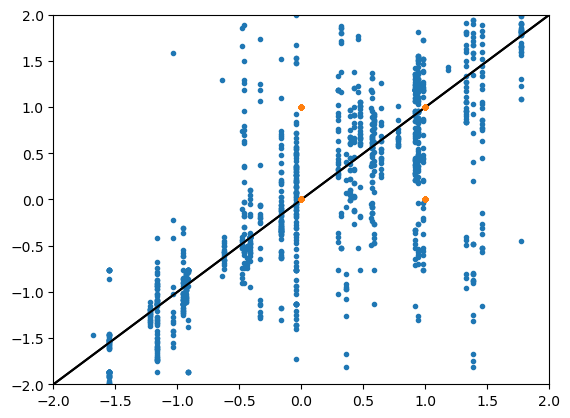

In [504]:
def validate_agains_ivs(*, model, ivs_x, ivs_y, metrics, print_tree = False):
    y_pred = model.predict(ivs_x)
    
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.axline((0, 0), slope=1, color="black")
    plt.plot(y_pred, ivs_y, ".")

    if print_tree:
        plt.figure(figsize=(10,10))
        r=tree.plot_tree(model)
        plt.show()
    
    return {metric_name: metric_f(ivs_y, y_pred) for (metric_name, metric_f) in metrics.items()}


myfile = Path('results.txt')
myfile.touch(exist_ok=True)
f = open(myfile, "a")

f.write("\n\n\n\nIndependent Validation Set - Final Conclusions:\n\n")
def write_and_print(txt: str, f):
    f.write(txt + "\n")
    print(txt)

write_and_print("\n\n\nformat of the model name:\n - model_type(tree vs linear vs ...), criterions, splitters, max_depths",f)
write_and_print("\n - model_type(tree vs linear vs ...), criterions, splitters, max_depths, max_features, min_samples_leaf, min_samples_splits, max_leaf_nodes\n\n",f)


write_and_print("--- Regressor ---",f)
regressor_name = best_regressor['name']
write_and_print(f"Model: {regressor_name}",f)
performance_on_ivs = validate_agains_ivs(model=best_regressor["model"], ivs_x=ivs_x_scaled, ivs_y=ivs_y_scaled, metrics={"mae": mean_absolute_error, "rve": explained_variance_score,"pearson_corr":pearsonr})#,print_tree="tree" in regressor_name)
write_and_print(f"Performance on IVS: {performance_on_ivs}",f)
write_and_print(f"MAE (re-scaled): {performance_on_ivs['mae'] * y_std} ",f)
write_and_print(f"RVE: {performance_on_ivs['rve']}",f)
write_and_print(f"Pearson Correlation Score: {performance_on_ivs['pearson_corr']}",f)
write_and_print("",f)
write_and_print("--- Classifier ---",f)
classifier_name=best_classifier['name']
write_and_print(f"Model: {classifier_name}",f)
performance_on_ivs = validate_agains_ivs(model=best_classifier["model"], ivs_x=ivs_x_scaled, ivs_y=ivs_y, metrics={"acc": accuracy_score, "f1": f1_score, "recall": recall_score, "precision": precision_score,"matthews_corr": matthews_corrcoef,"confusion_matrix": confusion_matrix})#,print_tree="tree" in classifier_name)
write_and_print(f"Performance on IVS: {performance_on_ivs}",f)
write_and_print(f"Accuracy: {performance_on_ivs['acc']}",f)
write_and_print(f"F1: {performance_on_ivs['f1']}",f)
write_and_print(f"Precision: {performance_on_ivs['precision']}",f)
write_and_print(f"Recall: {performance_on_ivs['recall']}",f)
write_and_print(f"Matthews Correlation Coefficient: {performance_on_ivs['matthews_corr']}",f)
write_and_print(f"Confusion Matrix:\n{pd.DataFrame(performance_on_ivs['confusion_matrix'])}",f)
# TODO fix plots

f.write("\n\n--------------------------------------------------------------------------------------------------------------------------------------------------------\n\n")
f.close()

# criterions, splitters, max_depths
# criterions, splitters, max_depths, max_features, min_samples_leaf, min_samples_splits, max_leaf_nodes